<a href="https://www.kaggle.com/code/avinashrola/spaceship-titanic?scriptVersionId=107809287" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load Data

In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
# shape

print("Train Data Shape :",train.shape)
print("Test Data Shape :",test.shape)

Train Data Shape : (8693, 14)
Test Data Shape : (4277, 13)


**Check Null Values**

In [7]:
print("Train data :\n")
print(train.isnull().sum())

Train data :

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [8]:
print("Test data :\n")
print(test.isnull().sum())

Test data :

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


**Check Duplicate Values**

In [9]:
print("Train data :",train.duplicated().sum())

Train data : 0


In [10]:
print("Test data :",test.duplicated().sum())

Test data : 0


# EDA

**Target Distribution**

<AxesSubplot:ylabel='Transported'>

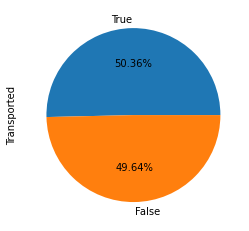

In [11]:
train['Transported'].value_counts().plot.pie(autopct='%1.2f%%')

The target is highly balanced, so we luckily don't have to consider techniques like under/over-sampling.

Text(0.5, 0, 'Age (years)')

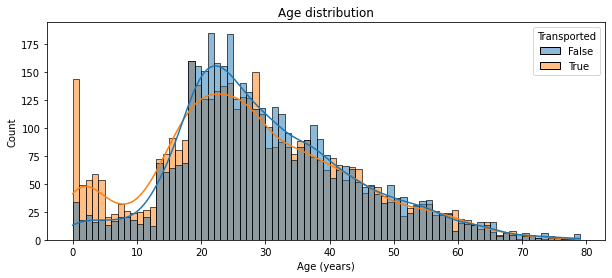

In [12]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

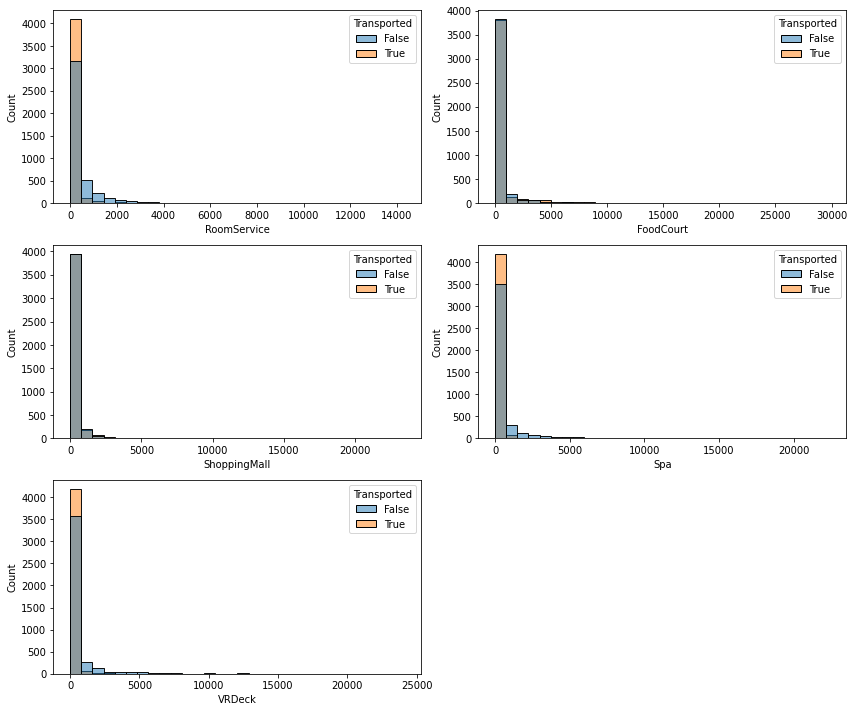

In [13]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(12,10))

for i,name in enumerate(exp_feats):
    ax = fig.add_subplot(3,2,i+1)
    sns.histplot(data=train, x=name, axes=ax, bins=30, kde=False, hue='Transported')

plt.tight_layout()  
plt.show()

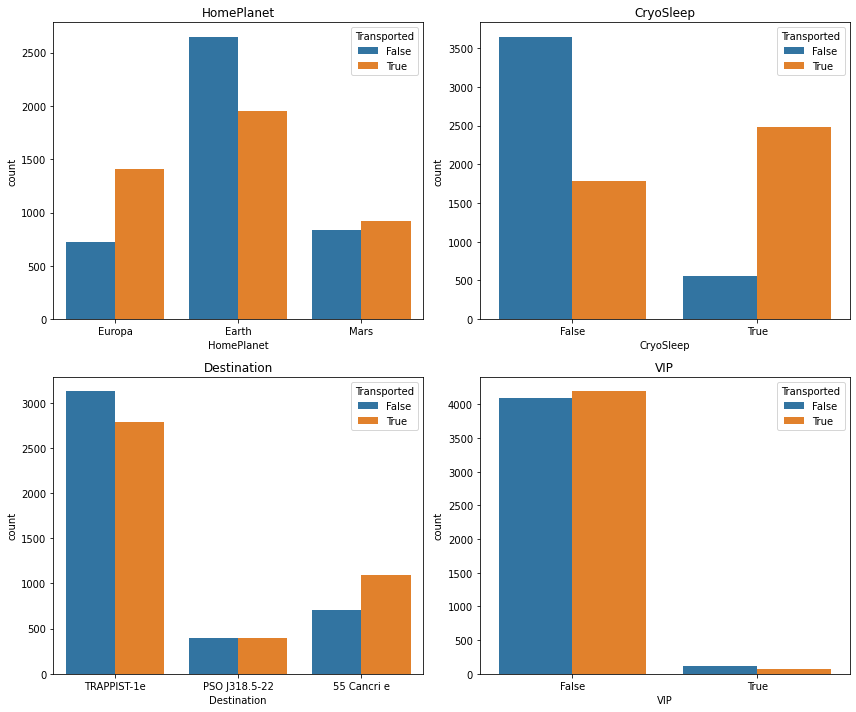

In [14]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


fig=plt.figure(figsize=(12,10))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(2,2,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [15]:
train.dropna(inplace = True)
train.shape

(6606, 14)

In [16]:
test.dropna(inplace = True)
test.shape

(3281, 13)

In [17]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [18]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


# Preprocessing

In [19]:
train.drop(['PassengerId','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Name','Cabin'], axis=1, inplace=True)
test.drop(['VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Name','Cabin'], axis=1, inplace=True)

In [20]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,Transported
0,Europa,False,TRAPPIST-1e,39.0,False
1,Earth,False,TRAPPIST-1e,24.0,True
2,Europa,False,TRAPPIST-1e,58.0,False
3,Europa,False,TRAPPIST-1e,33.0,False
4,Earth,False,TRAPPIST-1e,16.0,True


In [21]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age
0,0013_01,Earth,True,TRAPPIST-1e,27.0
1,0018_01,Earth,False,TRAPPIST-1e,19.0
2,0019_01,Europa,True,55 Cancri e,31.0
3,0021_01,Europa,False,TRAPPIST-1e,38.0
4,0023_01,Earth,False,TRAPPIST-1e,20.0


In [22]:
train = pd.get_dummies(train, columns=['CryoSleep','Destination','HomePlanet'], drop_first=True)
test = pd.get_dummies(test, columns=['CryoSleep','Destination','HomePlanet'], drop_first=True)

In [23]:
train.head()

,Age,Transported,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Europa,HomePlanet_Mars
0,39.0,False,0,0,1,1,0
1,24.0,True,0,0,1,0,0
2,58.0,False,0,0,1,1,0
3,33.0,False,0,0,1,1,0
4,16.0,True,0,0,1,0,0


In [24]:
test.head()

,PassengerId,Age,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Europa,HomePlanet_Mars
0,0013_01,27.0,1,0,1,0,0
1,0018_01,19.0,0,0,1,0,0
2,0019_01,31.0,1,0,0,1,0
3,0021_01,38.0,0,0,1,1,0
4,0023_01,20.0,0,0,1,0,0


In [25]:
x = train.drop('Transported', axis=1)

In [26]:
x

,Age,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Europa,HomePlanet_Mars
0,39.0,0,0,1,1,0
1,24.0,0,0,1,0,0
2,58.0,0,0,1,1,0
3,33.0,0,0,1,1,0
4,16.0,0,0,1,0,0
...,...,...,...,...,...,...
8688,41.0,0,0,0,1,0
8689,18.0,1,1,0,0,0
8690,26.0,0,0,1,0,0
8691,32.0,0,0,0,1,0


In [27]:
test1 = test.copy()

In [28]:
test1.head()

,PassengerId,Age,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,HomePlanet_Europa,HomePlanet_Mars
0,0013_01,27.0,1,0,1,0,0
1,0018_01,19.0,0,0,1,0,0
2,0019_01,31.0,1,0,0,1,0
3,0021_01,38.0,0,0,1,1,0
4,0023_01,20.0,0,0,1,0,0


In [29]:
test.drop('PassengerId',axis = 1, inplace=True)

In [30]:
sc = StandardScaler()

x = sc.fit_transform(x)


In [31]:
test = sc.transform(test)

In [32]:
test

array([[-0.13033256,  1.35379525, -0.32268927,  0.66604721, -0.58236117,
        -0.51081078],
       [-0.68082932, -0.73866414, -0.32268927,  0.66604721, -0.58236117,
        -0.51081078],
       [ 0.14491581,  1.35379525, -0.32268927, -1.50139508,  1.71714744,
        -0.51081078],
       ...,
       [ 0.76422466, -0.73866414, -0.32268927,  0.66604721, -0.58236117,
        -0.51081078],
       [ 0.35135209,  1.35379525, -0.32268927,  0.66604721, -0.58236117,
        -0.51081078],
       [ 0.97066094,  1.35379525,  3.09895649, -1.50139508, -0.58236117,
        -0.51081078]])

In [33]:
x = x
y = train['Transported']

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=50)

# Model

**1.Logistic Regression**

In [35]:
lr = LogisticRegression()

lr.fit(x_train,y_train)

LogisticRegression()

In [36]:
lr.score(x_train,y_train)

0.7142316426949281

**2.KNN**

In [37]:
knn = KNeighborsClassifier(n_neighbors=4,n_jobs=2)

knn.fit(x_train,y_train)

knn.score(x_train,y_train)

0.7409159727479182

**3.SVM**

In [38]:
svc = SVC()

svc.fit(x_train,y_train)

svc.score(x_train,y_train)

0.7350492051476154

**4.Random Forest**

In [39]:
rf = RandomForestClassifier()

rf.fit(x_train,y_train)

rf.score(x_train,y_train)

0.7715745647236941

**5.LGBM**

In [40]:
lgbm = LGBMClassifier()

lgbm.fit(x_train,y_train)

lgbm.score(x_train,y_train)

0.7528387585162756

**6.Naive Bayes**

In [41]:
nb = GaussianNB()

nb.fit(x_train,y_train)

nb.score(x_train,y_train)

0.7091218773656321

**Use Random Forest**

In [42]:
y_pred = rf.predict(test)

In [43]:
id = test1['PassengerId']

In [44]:
submission = pd.DataFrame({'PassengerId': id,'Transported': y_pred})
submission.to_csv('rf_submission.csv', index=False)

In [45]:
pd.read_csv('rf_submission.csv')

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
3276,9263_01,True
3277,9265_01,True
3278,9266_01,False
3279,9266_02,True
